In [1]:
%load_ext autoreload
%autoreload 2

# EEG models analysis

In [33]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import json

## Display learning curves

In [3]:
def results_path(model_date):
    return os.path.join("./Results/Pre_Training/EEG", model_date)

def get_results_model(model_date, kfold):
    file_test_results = os.path.join(results_path(model_date), 'EEG_linear_result.txt')
    results = pd.read_csv(file_test_results, sep=', ')
    if kfold:
        i = results[results['train_loss']=='train_loss'].index
        results = results.drop(i)
        fold = [k//(i[0]) for k in range(len(results))]
        results["fold"] = fold
        results = results.reset_index().drop(['index'], axis=1)
        results = results.astype(float)
    return results

def get_mean_min_max_kfold(results):
    n_epochs = int(max(results['#']))
    mean_values = []
    min_values = []
    max_values = []
    for i in range(n_epochs+1):
        mean_values.append(results[results['#']==i].mean())
        min_values.append(results[results['#']==i].min())
        max_values.append(results[results['#']==i].max())
    return pd.DataFrame(mean_values), pd.DataFrame(min_values), pd.DataFrame(max_values)

def get_results_segment_wise(model_date, results):
    config = json.load(open(f'Results/Pre_Training/EEG/{model_date}/configuration.json'))
    n_folds = config['k_fold']
    n_epochs = config['epochs']
    test_acc_C = []
    test_acc_F = []
    test_acc_A = []
    test_acc_all = []
    folds = []
    epochs = []
    for fold in range(1,n_folds+1):
        for epoch in range(n_epochs+1):
            folds.append(fold)
            epochs.append(epoch)
            stats = np.load(f'Results/Pre_Training/EEG/{model_date}/k_fold_{fold}/analysis_test_epoch_{epoch}.npy', allow_pickle=True).item()
            all_mat_segment = [m for m in stats['subject_conf_matrix'].values()]
            conf_mat_segment = np.sum(all_mat_segment, axis=0)
            conf_mat_segment = conf_mat_segment / np.sum(conf_mat_segment, axis=1)[0]
            test_acc_C.append(conf_mat_segment[0,0])
            test_acc_A.append(conf_mat_segment[1,1])
            test_acc_F.append(conf_mat_segment[2,2])
            test_acc_all.append(conf_mat_segment.diagonal().sum()/3)
    new_results = pd.DataFrame()
    new_results['test_acc_all'] = test_acc_all
    new_results['test_acc_C'] = test_acc_C
    new_results['test_acc_A'] = test_acc_A
    new_results['test_acc_F'] = test_acc_F
    new_results['fold'] = folds
    new_results['#'] = epochs
    for col in ['train_loss','test_loss']:
        new_results[col] = results[col]
    return new_results


def print_learning_curves(models, model_name, kfold=False, segmentWise=False, title=True, conf_mats=False):
    model_date = models[model_name]
    results = get_results_model(model_date=model_date, kfold=kfold)
    if segmentWise:
        results = get_results_segment_wise(model_date, results)
    if kfold:
        mean_values, min_values, max_values = get_mean_min_max_kfold(results)
    # Create figure with 2 subplots
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for col in ['train_loss', 'test_loss']:
        if kfold:
            plt.plot(mean_values[col], label=col+'_mean')
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.4)
        else:
            plt.plot(results[col], label=col)
    plt.ylabel('Loss')
    plt.legend()
    plt.xlabel('Epochs')
    if title:
        plt.title(f'Learning curves for model {model_name}')
    plt.subplot(1, 2, 2)
    acc_columns = [col for col in results.columns if 'test_acc' in col]
    for col in acc_columns:
        if kfold:
            plt.plot(mean_values[col], label=col+'_mean')
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.4)
        else:
            plt.plot(results[col], label=col)
    plt.legend()
    plt.xlabel('Epochs')
    if segmentWise:
        plt.ylabel('Accuracy segment-level')
    else:
        plt.ylabel('Accuracy subject-level')
    if title:
        plt.title(f'Learning curves for model {model_name}')
    plt.show()

    # Display confusion matrices
    if conf_mats:
        conf_mat_segment_avg = np.zeros((3,3))
        conf_mat_subject_avg = np.zeros((3,3))
        for fold in range(1,5):
            #Load stats for best epoch of this fold
            stats = np.load(f'Results/Pre_Training/EEG/{models[model_name]}/k_fold_{fold}/analysis_test_epoch_pre-training.npy', allow_pickle=True).item()
            all_mat_segment = [m for m in stats['subject_conf_matrix'].values()]
            conf_mat_segment = np.sum(all_mat_segment, axis=0)
            conf_mat_segment = conf_mat_segment / np.sum(conf_mat_segment, axis=1)[0]
            conf_mat_segment_avg += conf_mat_segment
            conf_mat_subject_avg += stats['voting_norm_conf_matrix']
        conf_mat_segment_avg /= 4
        conf_mat_subject_avg /= 4
        with np.printoptions(precision=2, suppress=True):
            print('Segment-level confusion matrix:')
            print(conf_mat_segment_avg)
            print('Subject-level confusion matrix:')
            print(conf_mat_subject_avg)
    return results

def compare_learning_curves(models, kfold=False, segmentWise=False):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    col="test_loss"
    for model_name, model_date in models.items():
        results = get_results_model(model_date=model_date, kfold=kfold)
        if segmentWise:
            results = get_results_segment_wise(model_date, results)
        if kfold:
            mean_values, min_values, max_values = get_mean_min_max_kfold(results)
            plt.plot(mean_values[col], label=model_name)
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.4)
        else:
            plt.plot(results[col], label=model_name)
    plt.ylabel('Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.title(f'Learning curve for {col}')

    plt.subplot(1, 2, 2)
    col = 'test_acc_all'
    for model_name, model_date in models.items():
        results = get_results_model(model_date=model_date, kfold=kfold)
        if segmentWise:
            results = get_results_segment_wise(model_date, results)
        if kfold:
            mean_values, min_values, max_values = get_mean_min_max_kfold(results)
            plt.plot(mean_values[col], label=model_name)
            plt.fill_between(min_values.index, min_values[col], max_values[col], alpha=0.2)
        else:
            plt.plot(results[col], label=model_name)
    plt.legend()
    plt.xlabel('Epochs')
    if segmentWise:
        plt.ylabel('Accuracy segment-level')
    else:
        plt.ylabel('Accuracy subject-level')
    plt.ylim(0,1)
    plt.title(f'Learning curve for {col}')
    plt.show()

/var/tmp/ipykernel_23332/2524478903.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv(file_test_results, sep=', ')
/var/tmp/ipykernel_23332/2524478903.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv(file_test_results, sep=', ')
/var/tmp/ipykernel_23332/2524478903.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  results = pd.read_csv(file_test_results, sep=', '

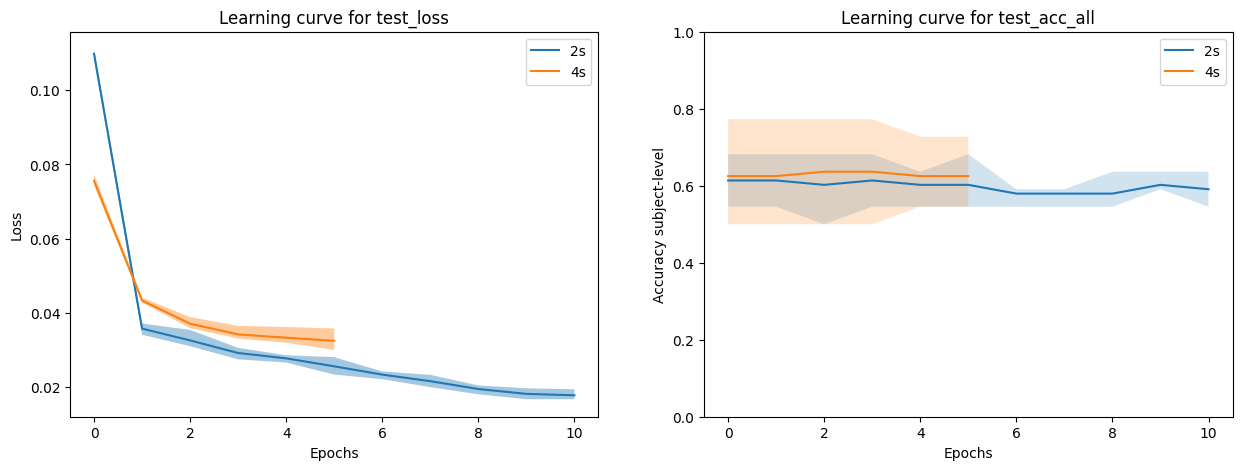

In [170]:
# Write reference of models to analyse with a name to identify them
models = {"500_epochs_2s_seed_1234":"2024-10-11_14-02",
          "500_epochs_2s_seed_17":"2024-10-11_19-29",
          "params_other_team":"2024-10-15_12-19",
          "newest_model_unbalanced":"2024-10-16_08-04"}

models = {"seed 1234":"2024-11-05_06-49",
          "4fold split 1":"2024-11-04_19-18",
          "4fold split 2":"2024-11-05_06-49",
          "seed 2024":"2024-11-04_20-03",
          "seed 42": "2024-11-04_20-37",
          "seed 3407": "2024-11-04_21-16",
          "seed 204110176": "2024-11-04_22-28",
          "zheyun_params":"2024-11-05_15-16",
          "fig_report":'2024-11-13_13-59',
          "small_model":"2024-11-06_10-47",
          }

models_same = {"model1":"2024-11-14_10-25",
               "model2":"2024-11-14_10-37"}

models_rep_dim = {'8':'2024-11-15_08-08',
                  '16':"2024-11-14_13-36",
                  '32':"2024-11-14_13-53",
                  '64':"2024-11-14_14-11",
                  '128':"2024-11-14_11-25",
                  '320':"2024-11-14_14-29"}

models_size = {'base':"2024-11-14_11-25",
               'divided by 2':"2024-11-14_15-08",
               "divided by 4":"2024-11-14_15-30",
               "divided by 8":"2024-11-15_08-26",
               #"divide by 8, rep_size 2":"2024-11-15_09-57"
               }

models_seeds = {"1234":"2024-11-14_18-48",
                "42":'2024-11-14_17-35',
                "2024":"2024-11-14_17-56",
                "4503":"2024-11-14_18-16",}

models_outliers = {"no":"2024-11-14_11-25",
                   "yes":"2024-11-14_18-37"}

models_folds = {'split 1':"2024-11-14_11-25",
                'split 2':"2024-11-14_18-48",
                "split 3":"2024-11-14_19-20",
                }

models_overlap = {'0':'2024-11-14_11-25',
                  '0.5':'2024-11-15_08-55'}

models_duration = {'2s':"2024-11-14_15-08",
                   "4s":'2024-11-15_14-46'}
all_models = {'8':'2024-11-15_08-08',
                  '16':"2024-11-14_13-36",
                  '32':"2024-11-14_13-53",
                  '64':"2024-11-14_14-11",
                  '128':"2024-11-14_11-25",
                  '320':"2024-11-14_14-29",
                  'base':"2024-11-14_11-25",
               'divide by 2':"2024-11-14_15-08",
               "divide by 4":"2024-11-14_15-30",
               "divide by 8":"2024-11-15_08-26",
               "1234":"2024-11-14_18-48",
                "42":'2024-11-14_17-35',
                "2024":"2024-11-14_17-56",
                "4503":"2024-11-14_18-16",
                "no outliers":"2024-11-14_18-37",
                'fold 2':"2024-11-14_18-48",
                "fold 3":"2024-11-14_19-20",}
#results = print_learning_curves(models, "zheyun_params", kfold=True)
#results = print_learning_curves(models_wrong_seeds, "seed 42", kfold=True, segmentWise=False, title=False, conf_mats=True)
compare_learning_curves(models_duration, kfold=True, segmentWise=False)

In [162]:
def f1_scores(cm_input):
    cm = cm_input.copy()
    tp = cm.copy().diagonal()
    np.fill_diagonal(cm, 0)
    fp = cm.sum(axis=1)
    fn = cm.sum(axis=0)
    return 2*tp/(2*tp+fn+fp)

def draw_boxplots(models, metric='test_acc_segment', xlabel='model'):
    list_folds = []
    for model_name, model_date in models.items():
        config = json.load(open(f'Results/Pre_Training/EEG/{model_date}/configuration.json'))
        n_folds = config['k_fold']
        for fold in range(1,n_folds+1):
            stats = np.load(f'Results/Pre_Training/EEG/{model_date}/k_fold_{fold}/analysis_test_epoch_pre-training.npy', allow_pickle=True).item()
            # Compute accuracies
            test_acc_voting = np.mean(stats['voting_class_accuracy'])
            all_mat_segment = [m for m in stats['subject_conf_matrix'].values()]
            segment_cm = np.sum(all_mat_segment, axis=0)
            segment_cm_prop = segment_cm / np.sum(segment_cm, axis=1)[0]
            test_acc_segment = segment_cm_prop.diagonal().mean()
            # Compute f1
            voting_cm = stats['voting_conf_matrix']
            f1_voting = f1_scores(voting_cm).mean()
            f1_segment = f1_scores(segment_cm).mean()
            list_folds.append({'model':model_name, "fold":fold, 
                               'test_acc_voting':test_acc_voting, 'test_acc_segment':test_acc_segment,
                               'test_f1_voting':f1_voting, "test_f1_segment":f1_segment})
    df = pd.DataFrame(list_folds)

    # Draw boxplots
    plt.figure(figsize=(6,4))
    ax=sns.boxplot(data=df, x='model', y=metric, hue='model', fill=True, whis=(0,100), width=.4)
    sns.stripplot(data=df, x='model', y=metric, ax=ax, hue='fold', palette="light:#000")
    ax.set_ylim(0.3,0.7)
    ax.set_xlabel(xlabel)
    if "acc" in metric: ylabel="Accuracy"
    if "f1" in metric: ylabel="F1 score"
    if "segment" in metric: ylabel += " segment-level"
    if "voting" in metric: ylabel += " subject-level"
    ax.set_ylabel(ylabel)
    # adding transparency to colors
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .1))
    plt.show()

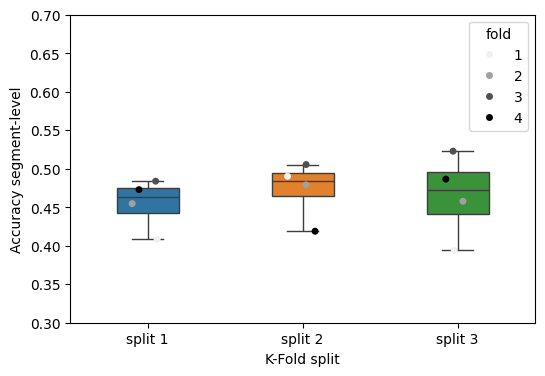

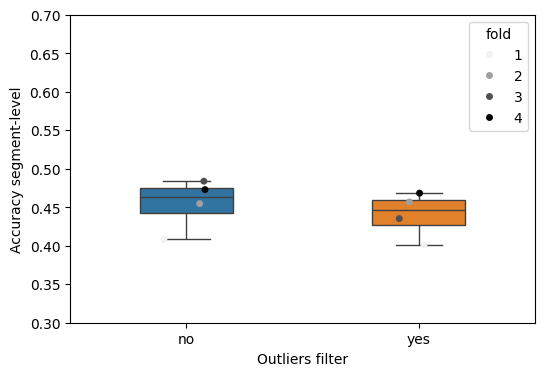

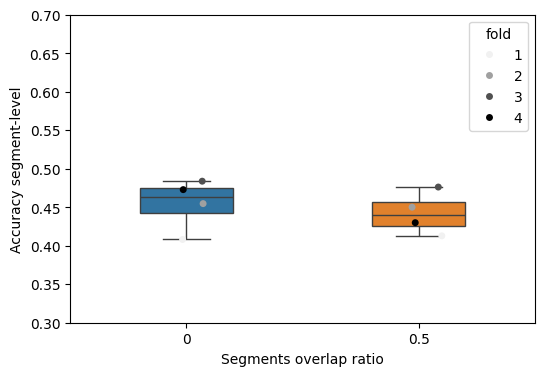

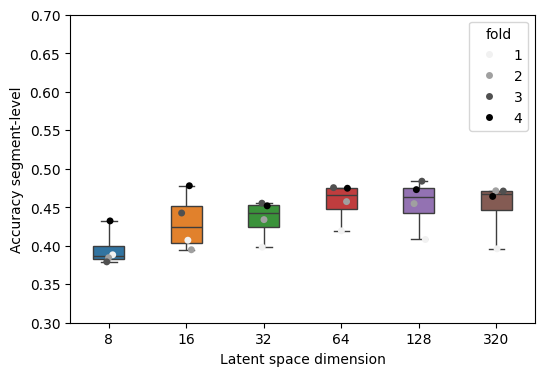

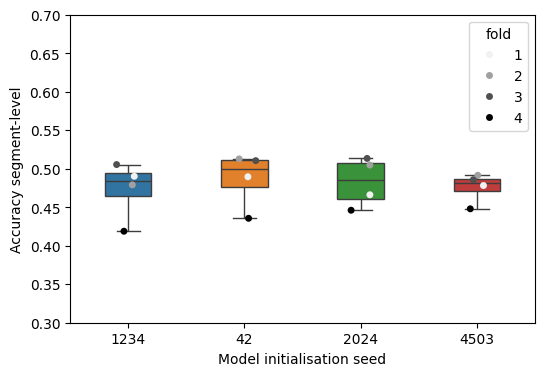

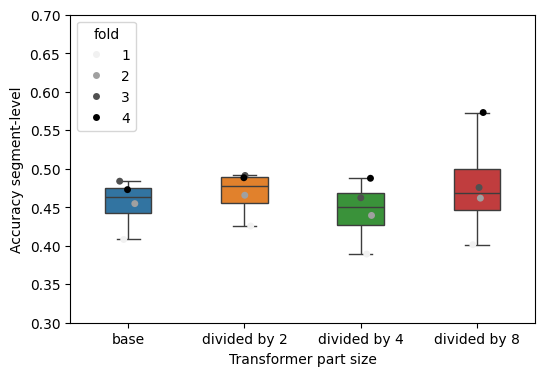

In [168]:
metric = "test_acc_segment"
draw_boxplots(models_folds, metric, xlabel='K-Fold split')
draw_boxplots(models_outliers, metric, xlabel='Outliers filter')
draw_boxplots(models_overlap, metric, xlabel="Segments overlap ratio")
draw_boxplots(models_rep_dim, metric, xlabel='Latent space dimension')
draw_boxplots(models_seeds, metric, xlabel='Model initialisation seed')
draw_boxplots(models_size, metric, xlabel='Transformer part size')

In [ ]:
cm = np.array([[8,1,1],[6,5,1],[3,3,3]])

f1_scores(cm)

[[8 1 1]
 [6 5 1]
 [3 3 3]]


array([0.59259259, 0.47619048, 0.42857143])

In [115]:
cm = np.array([[8,1,1],[6,5,1],[3,3,3]], dtype=np.float32)
print(cm)
cm.diagonal()

[[8. 1. 1.]
 [6. 5. 1.]
 [3. 3. 3.]]


array([8., 5., 3.], dtype=float32)

## Try fitting ML model to embeddings

/opt/conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cleaned up TensorBoard directory: summary
Current root path (path to EEG dataset): ./Dataset/EEG/EEG/
train: 70 sub = 18 F (4166, 4166) 29 A (7941, 7941) 23 C (6658, 6658)

test: 18 sub = 7 A (2087, 2087) 5 F (1239, 1239) 6 C (1678, 1678)

(18765, 4, 200) (0, 0) (5004, 4, 200)


2024-10-21 19:43:46,830 | INFO : 18765 samples will be used for training
2024-10-21 19:43:46,832 | INFO : Train Data Shape is #18765 samples, 4 channels, 200 time steps 
2024-10-21 19:43:46,832 | INFO : 5004 samples will be used for testing
2024-10-21 19:43:46,841 | INFO : Model:
Seires2Vec(
  (embed_layer): DisjoinEncoder(
    (temporal_CNN): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 8), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (spatial_CNN): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 1), stride=(1, 1), padding=valid)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (rep_CNN): Sequential(
      (0): Conv1d(16, 128, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
  )
  (embed_layer_f): Disjoi

Loaded model from ./Results/Pre_Training/EEG/2024-10-16_08-04/checkpoints/EEG_model_last.pth. Epoch: 26


/home/pauli/self-supervised-learning-eeg/models/Series2Vec/Series2Vec.py:44: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  x_f = torch.fft.fft(x).float()


NameError: name 'root_path' is not defined

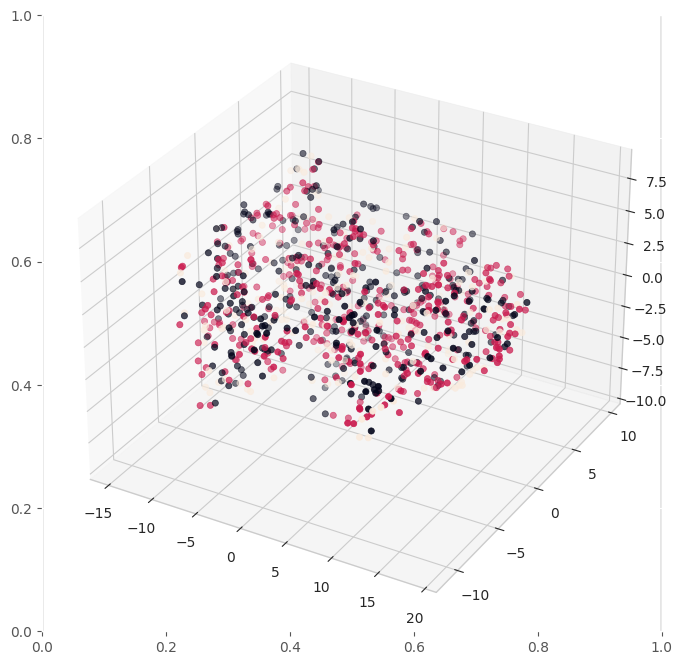

In [5]:
from visualize import load_config_from_json, visualize
from models.model_factory import Model_factory
from Dataset.dataloader import data_loader, dataset_class
from torch.utils.data import DataLoader
from torch import tensor
from Dataset.dataloader import dataset_class
from utils.utils import load_model
from models.Series2Vec.S2V_training import S2V_make_representation

problem = "EEG"
root_path = "./"
result_path = "Results/Pre_Training/EEG/2024-10-16_08-04"
config = load_config_from_json(root_path, result_path, problem)
Data = data_loader(config, is_analysis=True)
model = Model_factory(config, Data)

# --------------------------------- Load Data ---------------------------------
train_dataset = dataset_class(Data['train_data'], Data['train_label'], config)
test_dataset = dataset_class(Data['test_data'], Data['test_label'], config)

train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

# --------------------------------- Load Model --------------------------------
SS_Encoder = load_model(model, model_path=config['model_dir'], optimizer=None)  # Loading the model
SS_Encoder.to(config['device'])
train_repr, train_labels = S2V_make_representation(SS_Encoder, train_loader)
test_repr, test_labels = S2V_make_representation(SS_Encoder, test_loader)

# ------------------------------- Visualize Test ------------------------------
visualize(X=train_repr, 
          y=train_labels,
          reducer_type='tsne', # 'tsne', 'umap''
          problem=problem, 
          n_components=3, # 2, 3
          n_points=1000
          )


In [6]:
from Dataset.dataloader import data_loader
from torch import tensor

In [7]:
import numpy as np
subjects = Data['train_subjects']
ids_group = [[sub.participant_id]*len(sub.epochs) for sub in subjects]

import itertools
ids_group = np.array(list(itertools.chain.from_iterable(ids_group)))
ids_group.shape


KeyError: 'train_subjects'

In [10]:
from Dataset.EEG.EEG.EEG_Loader import load_participants

subjects = load_participants("Dataset/EEG/EEG/participants.tsv")
subjects = subjects.set_index('participant_id')
subjects.to_dict()

train_gender = tensor(np.array([gender_encoding(subjects['Gender'][ID]) for ID in Data['train_ids']]))
test_gender = tensor(np.array([gender_encoding(subjects['Gender'][ID]) for ID in Data['test_ids']]))

train_age = tensor(np.array([subjects['Age'][ID] for ID in Data['train_ids']]))
test_age = tensor(np.array([subjects['Age'][ID] for ID in Data['test_ids']]))

In [9]:
def gender_encoding(gender_str):
    if gender_str == 'F':
        return 0
    else:
        return 1

NameError: name 'root_path' is not defined

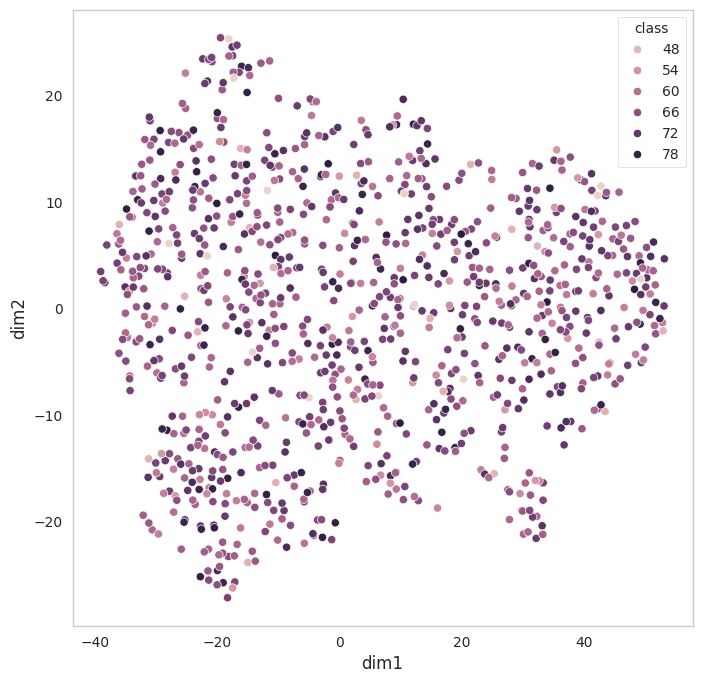

In [11]:
# ------------------------------- Visualize Test ------------------------------
visualize(X=train_repr, 
          y=train_age,
          reducer_type='tsne', # 'tsne', 'umap''
          problem=problem, 
          n_components=2, # 2, 3
          n_points=1000
          )

In [ ]:
# Create SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create pipeline
clf = SVC(C=1, gamma=2)
clf.fit(train_repr[:10].cpu(), train_age[:10].cpu())
print("Training done")
y_pred = clf.predict(test_repr.cpu())

print(classification_report(test_age, y_pred))

## Try different hyperparameters

In [ ]:
# 2. Change init seed but same folds
os.system('/opt/conda/envs/py38/bin/python main.py --epochs=10') #seed 1234, for all below, the seed for split is 1234
os.system('python main.py --epochs=10 --seed=42 --create_data=False')
os.system('python main.py --epochs=10 --seed=2024 --create_data=False')
os.system('python main.py --epochs=10 --seed=4503 --create_data=False')

# 3. Reject outliers
os.system('python main.py --epochs=10 --flat_threshold=3.63 --reject_threshold=6.14')

# 4. Representation dim
os.system('python main.py --epochs=10 --rep_size=16')
os.system('python main.py --epochs=10 --rep_size=32 --create_data=False')
os.system('python main.py --epochs=10 --rep_size=64 --create_data=False')
os.system('python main.py --epochs=10 --rep_size=320 --create_data=False') #Original param

# 5. Model's size
os.system('python main.py --epochs=10 --dim_ff=128 --emb_size=8 --num_heads=4 --create_data=False') #All transformer's params /2
os.system('python main.py --epochs=10 --dim_ff=64 --emb_size=4 --num_heads=2 --create_data=False') #All transformer /4

# 6. Same params but different fold
os.system('/opt/conda/envs/py38/bin/python main.py --epochs=0 --seed=2024') # Useless experiment, just to create data
os.system('python main.py --epochs=10 --seed=1234 --create_data=False') # split with seed 2024 but model initialised 1234

Cleaned up TensorBoard directory: summary
Current root path (path to EEG dataset): /home/pauli/self-supervised-learning-eeg/Dataset/EEG/EEG/


2024-11-14 11:21:29,482 | INFO : Stored configuration file in 'Results/Pre_Training/EEG/2024-11-14_11-21'
2024-11-14 11:21:29,640 | INFO : Using device: cuda
